In [63]:



# Core libraries
import numpy as np
import pandas as pd
import os
import random

# Image and plotting
import cv2
import matplotlib.pyplot as plt

# ML / DL
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Explore input directory (optional)
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/drone-camera-image-dataset-of-agriculture-fields/Kaggle image/DJI_0109_h50.JPG
/kaggle/input/drone-camera-image-dataset-of-agriculture-fields/Kaggle image/DJI_0117.JPG
/kaggle/input/drone-camera-image-dataset-of-agriculture-fields/Kaggle image/DJI_0114_h40.JPG
/kaggle/input/drone-camera-image-dataset-of-agriculture-fields/Kaggle image/DJI_0025-h60.JPG
/kaggle/input/drone-camera-image-dataset-of-agriculture-fields/Kaggle image/DJI_0018-h80.JPG
/kaggle/input/drone-camera-image-dataset-of-agriculture-fields/Kaggle image/DJI_0035-h40.JPG
/kaggle/input/drone-camera-image-dataset-of-agriculture-fields/Kaggle image/DJI_0100_h40.JPG
/kaggle/input/drone-camera-image-dataset-of-agriculture-fields/Kaggle image/DJI_0027-h55.JPG
/kaggle/input/drone-camera-image-dataset-of-agriculture-fields/Kaggle image/DJI_0113.JPG
/kaggle/input/drone-camera-image-dataset-of-agriculture-fields/Kaggle image/DJI_0111_h55.JPG
/kaggle/input/drone-camera-image-dataset-of-agriculture-fields/Kaggle image/DJ

In [64]:
import os

base_path = "/kaggle/input/drone-camera-image-dataset-of-agriculture-fields/Kaggle image"
files = os.listdir(base_path)

print("Total images:", len(files))
print(files[:5])


Total images: 70
['DJI_0109_h50.JPG', 'DJI_0117.JPG', 'DJI_0114_h40.JPG', 'DJI_0025-h60.JPG', 'DJI_0018-h80.JPG']


Loading: /kaggle/input/drone-camera-image-dataset-of-agriculture-fields/Kaggle image/DJI_0109_h50.JPG


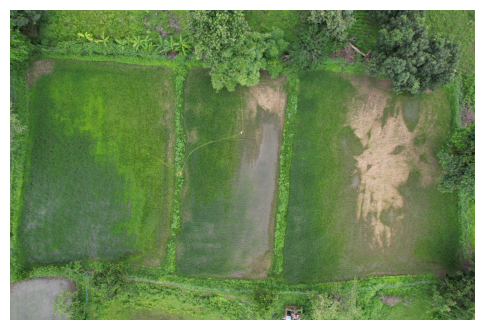

In [65]:
import cv2
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

""" 
len 
for file in range(len):
  img_path = os.path.join(base_path, file)
"""

img_path = os.path.join(base_path, files[0])
print("Loading:", img_path)

img = cv2.imread(img_path)

if img is None:
    raise ValueError("Image not loaded — path issue")

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")
plt.show()


Loading: /kaggle/input/drone-camera-image-dataset-of-agriculture-fields/Kaggle image/DJI_0109_h50.JPG
Number of patches: 1176


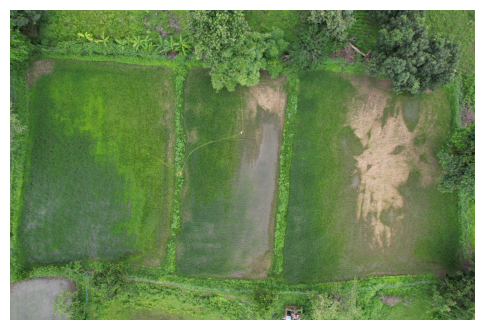

In [66]:



import numpy as np

def extract_patches(image, patch_size=128):
    patches = []
    h, w, _ = image.shape
    for y in range(0, h, patch_size):
        for x in range(0, w, patch_size):
            patch = image[y:y+patch_size, x:x+patch_size]
            # Skip incomplete border patches (optional)
            if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
                continue
            patches.append(patch)
    return patches

# Quick check on a sample image
img_path = os.path.join(base_path, files[0])
print("Loading:", img_path)
img = cv2.imread(img_path)
if img is None:
    raise ValueError("Image not loaded — path issue")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

patches = extract_patches(img)
print("Number of patches:", len(patches))
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")
plt.show()



In [67]:
def auto_label_patch(patch):
    R = patch[:,:,0].astype(float)
    G = patch[:,:,1].astype(float)
    B = patch[:,:,2].astype(float)
    eps = 1e-5

    ExG = 2*G - R - B
    blue_ratio = B / (R + G + B + eps)

    if np.mean(ExG) > 25:
        return 0   # vegetation
    elif np.mean(blue_ratio) > 0.4:
        return 1   # water
    else:
        return 2   # soil


In [68]:



# max_images = 8  # start with 5; increase slowly if RAM ok

# images = []
# labels = []

# for i, fname in enumerate(files):
#     if i >= max_images:
#         break
#     img = cv2.imread(os.path.join(base_path, fname))
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     patches = extract_patches(img)
#     for p in patches:
#         images.append(cv2.resize(p, (224, 224)))
#         labels.append(auto_label_patch(p))

# images = np.array(images)
# labels = np.array(labels)
# print("Total patches:", len(images))


# # Class distribution
# unique, counts = np.unique(labels, return_counts=True)
# for u, c in zip(unique, counts):
#     print(f"Class {u}: {c} patches")


# We will NOT build a big images array anymore; use generators instead



In [69]:
from tensorflow.keras.utils import Sequence

class PatchGenerator(Sequence):
    def __init__(self, file_list, base_path, batch_size=32, patch_size=128, shuffle=True):
        self.file_list = list(file_list)
        self.base_path = base_path
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.file_list))
        self.on_epoch_end()

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        # approximate steps/epoch: ~100 patches per image
        # images_per_epoch = 5 
        # patches_per_image = 100
        # total_patches = images_per_epoch * self.batch_size
        # return max(1, total_patches // self.batch_size)
        # 1 step per image per epoch
        return len(self.file_list)

    def __getitem__(self, idx):
        while True:
            img_idx = self.indexes[idx % len(self.file_list)]
            fname = self.file_list[img_idx]
            path = os.path.join(self.base_path, fname)
    
            img = cv2.imread(path)
            if img is None:
                # Skip unreadable / non-image files
                print("Warning: could not read", path)
                idx = (idx + 1) % len(self.file_list)
                continue
    
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            patches = extract_patches(img, patch_size=self.patch_size)
    
            X_batch, y_batch = [], []
            for p in patches:
                X_batch.append(cv2.resize(p, (224, 224)))
                y_batch.append(auto_label_patch(p))
                if len(X_batch) == self.batch_size:
                    break
    
            if len(X_batch) == 0:
                # No valid patches, move to next image
                idx = (idx + 1) % len(self.file_list)
                continue
    
            X_batch = np.array(X_batch, dtype="float32")
            y_batch = np.array(y_batch)
    
            X_batch = preprocess_input(X_batch)
            return X_batch, y_batch



In [70]:


# # 70% train, 15% val, 15% test with stratification

# X_train, X_temp, y_train, y_temp = train_test_split(
#     images, labels, test_size=0.3, stratify=labels, random_state=42
# )

# X_val, X_test, y_val, y_test = train_test_split(
#     X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
# )

# # ResNet preprocessing
# X_train_p = preprocess_input(X_train.astype("float32"))
# X_val_p   = preprocess_input(X_val.astype("float32"))
# X_test_p  = preprocess_input(X_test.astype("float32"))

# print("Train:", X_train_p.shape, "Val:", X_val_p.shape, "Test:", X_test_p.shape)



# Split the 70 image files into train/val/test by image
train_files, temp_files = train_test_split(files, test_size=0.3, random_state=42)
val_files, test_files   = train_test_split(temp_files, test_size=0.5, random_state=42)

print("Train images:", len(train_files))
print("Val images:", len(val_files))
print("Test images:", len(test_files))

train_gen = PatchGenerator(train_files, base_path, batch_size=32, patch_size=128, shuffle=True)
val_gen   = PatchGenerator(val_files, base_path, batch_size=32, patch_size=128, shuffle=False)
test_gen  = PatchGenerator(test_files, base_path, batch_size=32, patch_size=128, shuffle=False)


Train images: 49
Val images: 10
Test images: 11


In [71]:
# After creating X_train_p, X_val_p, X_test_p
# del X_train, X_val, X_test
# del images
# import gc
# gc.collect()


In [72]:



base = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base.trainable = False

x = base.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)            # NEW: regularization
out = Dense(3, activation="softmax")(x)

model = Model(inputs=base.input, outputs=out)
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()



Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,371 (90.98 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [73]:



# checkpoint = ModelCheckpoint("best_model.h5", monitor="val_accuracy",
#                              save_best_only=True, mode="max", verbose=1)
# rlrop = ReduceLROnPlateau(monitor="val_loss", factor=0.5,
#                           patience=3, verbose=1)
# early = EarlyStopping(monitor="val_loss", patience=7,
#                       restore_best_weights=True, verbose=1)

# history = model.fit(
#     X_train_p, y_train,
#     validation_data=(X_val_p, y_val),
#     epochs=30,
#     batch_size=16,
#     callbacks=[checkpoint, rlrop, early]
# )


checkpoint = ModelCheckpoint("best_model.h5", monitor="val_accuracy",
                             save_best_only=True, mode="max", verbose=1)
rlrop = ReduceLROnPlateau(monitor="val_loss", factor=0.5,
                          patience=3, verbose=1)
early = EarlyStopping(monitor="val_loss", patience=7,
                      restore_best_weights=True, verbose=1)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[checkpoint, rlrop, early]
)


Epoch 1/30
39/49 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step - accuracy: 0.7551 - loss: 0.6290Warning: could not read /kaggle/input/drone-camera-image-dataset-of-agriculture-fields/Kaggle image/extra
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.7793 - loss: 0.5719
Epoch 1: val_accuracy improved from -inf to 0.95312, saving model to best_model.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 455ms/step - accuracy: 0.7813 - loss: 0.5672 - val_accuracy: 0.9531 - val_loss: 0.1006 - learning_rate: 0.0010
Epoch 2/30
47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9493 - loss: 0.1336Warning: could not read /kaggle/input/drone-camera-image-dataset-of-agriculture-fields/Kaggle image/extra
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9491 - loss: 0.1335
Epoch 2: val_accuracy improved from 0.95312 to 0.95938, saving model to best_model.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 369ms/step - accuracy: 0.9491 - loss: 0.1334 - val_accuracy: 0.9594 - val_loss: 0.0908 - learning_rate: 0.0010
Epoch 3/30
 9/49 ━━━━━━━━━━━━━━━━━━━━ 11s 279ms/step - accuracy: 0.9695 - loss: 0.0583Warning: could not read /kaggle/input/drone-camera-image-dataset-of-agriculture-fields/Kaggle image/extra
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.9621 - loss: 0.0802
Epoch 3: val_accuracy improved from 0.95938 to 0.97188, saving model to best_model.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 358ms/step - accuracy: 0.9621 - loss: 0.0804 - val_accuracy: 0.9719 - val_loss: 0.0606 - learning_rate: 0.0010
Epoch 4/30
19/49 ━━━━━━━━━━━━━━━━━━━━ 9s 306ms/step - accuracy: 0.9822 - loss: 0.0473Warning: could not read /kaggle/input/drone-camera-image-dataset-of-agriculture-fields/Kaggle image/extra
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.9726 - loss: 0.0655
Epoch 4: val_accuracy did not improve from 0.97188
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.9724 - loss: 0.0659 - val_accuracy: 0.9719 - val_loss: 0.0673 - learning_rate: 0.0010
Epoch 5/30
 2/49 ━━━━━━━━━━━━━━━━━━━━ 12s 268ms/step - accuracy: 0.9766 - loss: 0.0256Warning: could not read /kaggle/input/drone-camera-image-dataset-of-agriculture-fields/Kaggle image/extra
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.9731 - loss: 0.0667
Epoch 5: val_accuracy improved from 0.97188 to 0.97812, saving model to best_model.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 355ms/step - accuracy: 0.9731 - loss: 0.0668 - val_accuracy: 0.9781 - val_loss: 0.0434 - learning_rate: 0.0010
Epoch 6/30
37/49 ━━━━━━━━━━━━━━━━━━━━ 3s 289ms/step - accuracy: 0.9831 - loss: 0.0468Warning: could not read /kaggle/input/drone-camera-image-dataset-of-agriculture-fields/Kaggle image/extra
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9836 - loss: 0.0465
Epoch 6: val_accuracy improved from 0.97812 to 0.98438, saving model to best_model.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 362ms/step - accuracy: 0.9836 - loss: 0.0466 - val_accuracy: 0.9844 - val_loss: 0.0515 - learning_rate: 0.0010
Epoch 7/30
33/49 ━━━━━━━━━━━━━━━━━━━━ 4s 295ms/step - accuracy: 0.9739 - loss: 0.0623Warning: could not read /kaggle/input/drone-camera-image-dataset-of-agriculture-fields/Kaggle image/extra
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9762 - loss: 0.0577
Epoch 7: val_accuracy improved from 0.98438 to 0.99063, saving model to best_model.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 370ms/step - accuracy: 0.9763 - loss: 0.0574 - val_accuracy: 0.9906 - val_loss: 0.0324 - learning_rate: 0.0010
Epoch 8/30
 2/49 ━━━━━━━━━━━━━━━━━━━━ 13s 287ms/step - accuracy: 0.9922 - loss: 0.0437Warning: could not read /kaggle/input/drone-camera-image-dataset-of-agriculture-fields/Kaggle image/extra
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.9913 - loss: 0.0314
Epoch 8: val_accuracy did not improve from 0.99063
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 348ms/step - accuracy: 0.9913 - loss: 0.0313 - val_accuracy: 0.9844 - val_loss: 0.0510 - learning_rate: 0.0010
Epoch 9/30
10/49 ━━━━━━━━━━━━━━━━━━━━ 11s 288ms/step - accuracy: 0.9969 - loss: 0.0111Warning: could not read /kaggle/input/drone-camera-image-dataset-of-agriculture-fields/Kaggle image/extra
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.9891 - loss: 0.0301
Epoch 9: val_accuracy did not improve from 0.99063
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 358ms/step - accuracy: 0.9890 - loss: 0.0302 - va

In [75]:



# from sklearn.metrics import classification_report, confusion_matrix

# best_model = tf.keras.models.load_model("best_model.h5")

# loss, acc = best_model.evaluate(X_test_p, y_test, verbose=0)
# print("Test Accuracy:", acc)

# # Inspect which classes are actually present in y_test
# labels_present = np.unique(y_test)
# print("Labels present in test set:", labels_present)

# class_names_full = ["Vegetation", "Water", "Soil"]
# class_names_used = [class_names_full[i] for i in labels_present]

# y_pred_prob = best_model.predict(X_test_p, verbose=0)
# y_pred = np.argmax(y_pred_prob, axis=1)

# print("\nClassification report:")
# print(classification_report(
#     y_test,
#     y_pred,
#     labels=labels_present,
#     target_names=class_names_used
# ))

# print("\nConfusion matrix:")
# print(confusion_matrix(y_test, y_pred, labels=labels_present))



from sklearn.metrics import classification_report, confusion_matrix

best_model = tf.keras.models.load_model("best_model.h5")

loss, acc = best_model.evaluate(test_gen, verbose=0)
print("Test Accuracy:", acc)

class_names_full = ["Vegetation", "Water", "Soil"]

all_y_true, all_y_pred = [], []

for X_batch, y_batch in test_gen:
    preds = best_model.predict(X_batch, verbose=0)
    y_hat = np.argmax(preds, axis=1)
    all_y_true.extend(y_batch.tolist())
    all_y_pred.extend(y_hat.tolist())

all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)

labels_present = np.unique(all_y_true)
class_names_used = [class_names_full[i] for i in labels_present]

print("\nClassification report:")
print(classification_report(
    all_y_true,
    all_y_pred,
    labels=labels_present,
    target_names=class_names_used
))

print("\nConfusion matrix:")
print(confusion_matrix(all_y_true, all_y_pred, labels=labels_present))


Test Accuracy: 0.9659090638160706


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.title("Accuracy")
plt.legend()
plt.show()


In [ ]:



class_names = ["Vegetation", "Water", "Soil"]

def classify_patch(patch):
    p = cv2.resize(patch, (224, 224)).astype("float32")
    p_p = preprocess_input(np.expand_dims(p, axis=0))
    pred = best_model.predict(p_p)[0]
    if np.max(pred) < 0.6:
        return "Anomaly"
    return class_names[np.argmax(pred)]


In [ ]:




test_img = cv2.imread(os.path.join(base_path, files[0]))
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

patches = extract_patches(test_img)
overlay = np.zeros_like(test_img)

colors = {
    "Vegetation": [0, 255, 0],
    "Water": [0, 0, 255],
    "Soil": [255, 255, 0],
    "Anomaly": [255, 0, 0]
}

i = 0
h, w, _ = test_img.shape
patch_size = 128

for y in range(0, h, patch_size):
    for x in range(0, w, patch_size):
        if y + patch_size > h or x + patch_size > w:
            continue
        if i >= len(patches):
            break
        label = classify_patch(patches[i])
        overlay[y:y+patch_size, x:x+patch_size] = colors[label]
        i += 1

# Blend overlay with original
alpha = 0.5
final = (alpha * test_img + (1 - alpha) * overlay).astype("uint8")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(test_img)
plt.title("Original Drone Image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(final)
plt.title("Patch wise Land Cover Classification")
plt.axis("off")
plt.show()
#Colors: green – vegetation, blue – water, yellow – soil, red – anomaly.